<a href="https://colab.research.google.com/github/kushal134/EE610-Assignment1/blob/master/EE610_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE610 - Assignment 2**

In [ ]:
pip install opencv-python

We first import the necessary libraries which will be used in this assignment. I have also downloaded color images from the BSD dataset and uploaded them on the drive. I have then mounted the drive and load the images

In [ ]:
import numpy as np
import cv2
import glob
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import random

In [ ]:
#Mounting the drive to load the images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Prepare the training dataset** 

We first prepare the degradation model. I have defined two functions - a blur function and a gaussian noise function. For the blur function I have used the openCV library. Gaussian blur is implented using numpy. Each function takes in a parameter to control the extent of blurring/noise

To degrade the image, we first pass it through: (in order)

1) A 3,3 blur function

2) Gaussian noise with variance = 10

3) A 5,5 blur function

4) Gaussian noise with variance = 20

In [ ]:
def blurring(im, kernel = (3,3)):
  blurImg = cv2.blur(im,kernel) 
  # cv2_imshow(blurImg)
  return blurImg

def noise(im, variance):
  row,col,ch= im.shape
  sigma = np.sqrt(variance)      
  gauss = np.random.normal(0,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noiseImg = cv2.convertScaleAbs(im + gauss)
  # cv2_imshow(noiseImg)
  return noiseImg

def degrade(im):
  # im = cv2.imread(img_path)
  blur1 = blurring(im,(3,3))
  noise1 = noise(blur1,10)
  blur2 = blurring(noise1,(5,5))
  noise2 = noise(blur2,10)
  return im, noise2



### **Testing the degrade function on some images**

Lets look at some test images to see if our degrade function is realistic. We notice that our degrade function looks realistic, with some noise and some blurring. Hence this degrade function can be used to extract the patches and train the ML Model

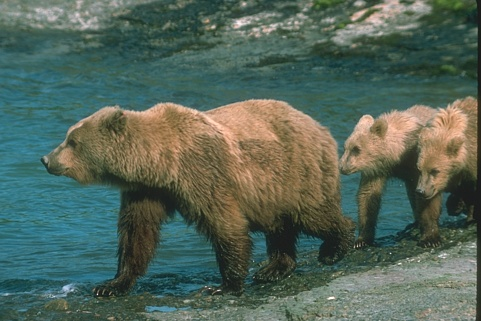

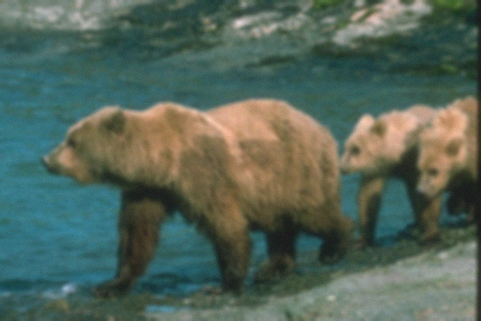

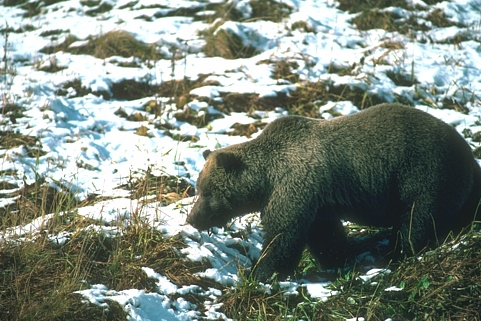

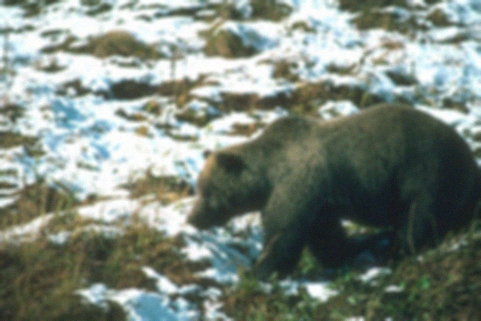

In [ ]:
im1 = cv2.imread('/content/drive/MyDrive/EE610_Assignment2/images/train/100075.jpg')
orig, deg = degrade(im1)
cv2_imshow(orig)
cv2_imshow(deg)

im2 = cv2.imread('/content/drive/MyDrive/EE610_Assignment2/images/train/100098.jpg')
orig, deg = degrade(im2)
cv2_imshow(orig)
cv2_imshow(deg)



### **Extracting the patch**

We extract a patch of W*W from the degraded images. I have chosen W = 27. We first store the 200 train images in an list and then extract 60 patches from each image ( I have used Prof. Amit Sethi's starter code for patch extraction).

Basically we specify a random integer location as the start of the patch from the image and then extract a W*W patch and store in the array

In [ ]:
image_list = [] #array containing the image arrays for training set

for filename in glob.glob('/content/drive/MyDrive/EE610_Assignment2/images/train/*.jpg'):  #loop over all the file paths
    im = cv2.imread(filename)
    image_list.append(im)

print(len(image_list))

200


In [ ]:
W = 27 #patch size W*W
num = 60 #extract 60 patches from an image
patches = np.empty((len(image_list),num,W,W,3), dtype=float) # Initilizing patch n-d array
central = np.empty((len(image_list),num,1,1,3), dtype=float) # Initilizing central pixel n-d array

for j in range(len(image_list)):
  im = image_list[j]
  orig, degraded = degrade(im)
  for i in range(num): # For number of patches
    
    x = random.randint(0, degraded.shape[0]-W) # Random x location so that the patch 
                                            # remains within image boundaries
    y = random.randint(0, degraded.shape[1]-W) # Random y location
                                            # remains within image boundaries
    patches[j,i,:,:,:] = degraded[x:x+W,y:y+W,:] # Extract patches
    central[j,i,:,:,:] = orig[x+int(W/2),y+int(W/2),:] #Extract the central pixel

print(patches.shape)
print(central.shape)
                                          

(200, 60, 27, 27, 3)
(200, 60, 1, 1, 3)


Now lets a define a function to extract w*w subpatches from the extracted patches. While training our model, we will vary w from 1 to W in steps of 3 and we will pass on these subpatches as our input to the model.

In [ ]:
def subpatch(w,patches = patches,W = W):
  sub_patches = np.empty((len(image_list),num,w,w,3), dtype=float)
  sub_patches = patches[:,:,int(W/2)-int(w/2):int(W/2)+int(w/2) + 1,int(W/2)-int(w/2):int(W/2)+int(w/2) + 1,:]
  return sub_patches
      


## **Training a Support Vector Machine (Regression) using Scikit Learn**

We import the necessary libraries first. We will use scikit learn.

In [15]:
import sklearn
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### **Training the model**

Here due to computational issues, we will only look at w = 1 to 13 in steps of 2 and evaluate the model performace

In [17]:
for w in [1 + i*2 for i in range(7)]:

  subpatches = subpatch(w,patches)

  #reshape array by flattening it
  x = subpatches.reshape((200,60,w*w*3)).reshape((12000,w*w*3))/255.0
  y = central.reshape((200,60,3)).reshape((200*60,3))/255.0

  #split train and validation data
  X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

  #Train the SVR, we use multi output regressor since there are 3 outputs
  clf = svm.SVR()
  mor = MultiOutputRegressor(clf)
  mor.fit(X_train, y_train)

  y_pred = mor.predict(X_val)

  # Evaluate the regressor
  mse_one = mean_squared_error(y_val[:,0], y_pred[:,0],squared = False)
  mse_two = mean_squared_error(y_val[:,1], y_pred[:,1],squared = False)
  mse_three = mean_squared_error(y_val[:,2], y_pred[:,2],squared = False)
  print(f"w = {w}")
  print(f'Mean RMSE: {(mse_one + mse_two + mse_three)/3}')
  print("Finished Training")
  print("--------------------------")

w = 1
Mean RMSE: 0.06391553657668386
Finished Training
--------------------------
w = 3
Mean RMSE: 0.06141010957214018
Finished Training
--------------------------
w = 5
Mean RMSE: 0.05855162042937698
Finished Training
--------------------------
w = 7
Mean RMSE: 0.057928643892391614
Finished Training
--------------------------
w = 9
Mean RMSE: 0.057944360369788755
Finished Training
--------------------------
w = 11
Mean RMSE: 0.05768742926833383
Finished Training
--------------------------
w = 13
Mean RMSE: 0.058881537041889066
Finished Training
--------------------------


Clearly, w = 5 and 7 give the best rmse validation error. Lets now try to predict an clean image using w = 5 (since it is faster)

### **Testing the model on held-out or private images**

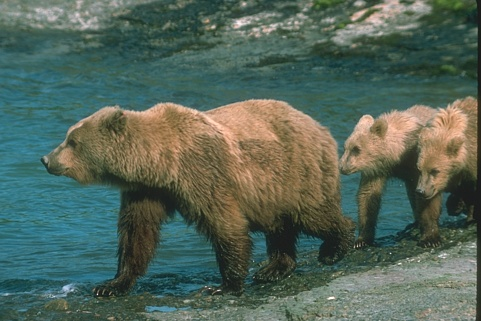

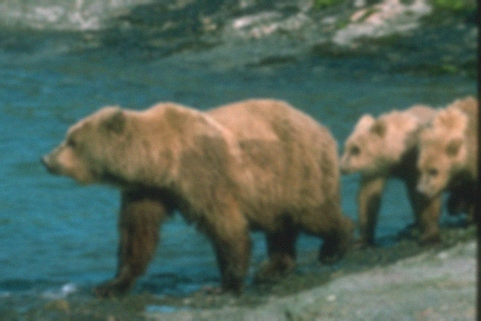

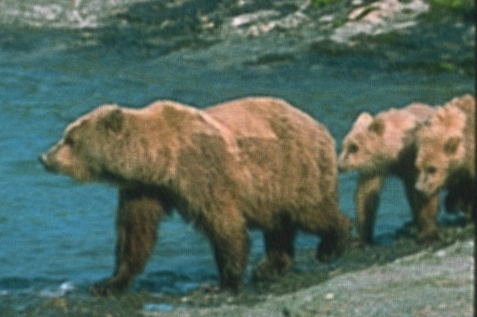

In [21]:
#train the model for w = 5
w = 5
subpatches = subpatch(w,patches)

#reshape array by flattening it
x = subpatches.reshape((200,60,w*w*3)).reshape((12000,w*w*3))/255.0
y = central.reshape((200,60,3)).reshape((200*60,3))/255.0

#split train and validation data
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

#Train the SVR, we use multi output regressor since there are 3 outputs
clf = svm.SVR()
mor = MultiOutputRegressor(clf)
mor.fit(X_train, y_train)



#predict clean image
im = cv2.imread('/content/drive/MyDrive/EE610_Assignment2/images/train/100075.jpg')
orig, degraded = degrade(im)

degraded_norm = degraded/255.0
#initialise empty array
clean_pred = np.empty(((im.shape[0] - w + 1),(im.shape[1] - w + 1),3), dtype=float)

#loop over and predict the clean pixel
for i in range(im.shape[0] - w + 1):
  for j in range(im.shape[1] - w + 1):
    clean_pred[i,j,:] = mor.predict(degraded_norm[i:i+w,j:j+w,:].flatten().reshape(1,-1))

restored_im = cv2.convertScaleAbs(clean_pred*255)
cv2_imshow(im)
cv2_imshow(degraded)
cv2_imshow(restored_im)


This is a very good restoration, a lot of the details has been restored.The image is still slightly fuzzy but its a very good restoration.

We will now look at another image

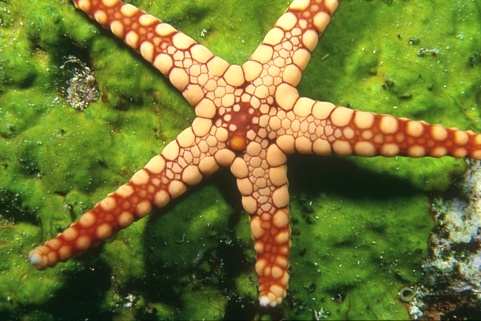

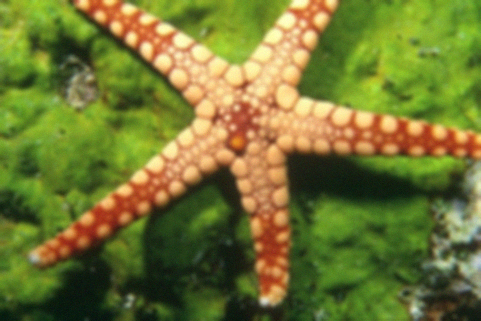

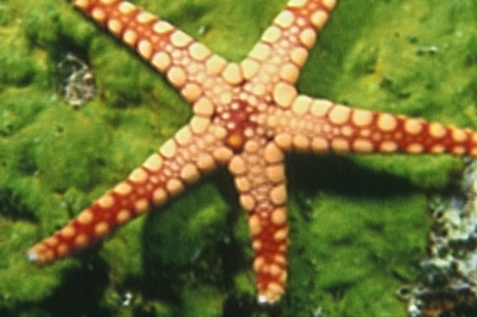

In [22]:
im = cv2.imread('/content/drive/MyDrive/EE610_Assignment2/images/train/12003.jpg')
orig, degraded = degrade(im)

degraded_norm = degraded/255.0
#initialise empty array
clean_pred = np.empty(((im.shape[0] - w + 1),(im.shape[1] - w + 1),3), dtype=float)

#loop over and predict the clean pixel
for i in range(im.shape[0] - w + 1):
  for j in range(im.shape[1] - w + 1):
    clean_pred[i,j,:] = mor.predict(degraded_norm[i:i+w,j:j+w,:].flatten().reshape(1,-1))

restored_im = cv2.convertScaleAbs(clean_pred*255)
cv2_imshow(im)
cv2_imshow(degraded)
cv2_imshow(restored_im)


Again, this is a good restoration. A lot of the details have been restored.

We will now look at CNNs and try to improve upon this performance

## **Training a Convolutional Neural Network using Pytorch**

Let us now look at a CNN to predict the clean central pixel. We will use pytorch and train some basic models and see how various parameters affect our model.

We will first import the necessary libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


Now we will extract subpatches using the previously defined function and then split the train and validation data in a 4:1 ratio. Thus we have 9600 train samples and 2400 validation samples

We will also flatten the array in one dimension and make it a 4d array from a 5d array

In [ ]:
print(patches.shape,central.shape)
w = 5
subpatches = subpatch(w,patches)

subpatch_2 = subpatches.reshape((200*num,w,w,3)).astype("uint8")
central_2 = central.reshape((200*num,1,1,3)).astype("uint8")

X_train, X_val, y_train, y_val = train_test_split(subpatch_2, central_2, test_size=0.20, random_state=42)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(200, 60, 27, 27, 3) (200, 60, 1, 1, 3)
(9600, 5, 5, 3) (2400, 5, 5, 3) (9600, 1, 1, 3) (2400, 1, 1, 3)


### **Creating the dataloader class and loading the data**

We now create a class to load our data, it is quite straightforward. We will also pass it through necessary trasnformations to make it compatible with the CNN, we first convert to PILImage. This will normalise the values to 0-1 and then we convert it to a tensor which will be our input type to the model

In [ ]:
class BSDSDataset(Dataset):

  def __init__(self,X,Y):
        self.X = X
        self.Y = Y
  
  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        X = self.X[index]
        X = self.transform(X)
        Y = self.Y[index]
        Y = self.transform(Y)
        return X,Y

  transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        ])

We will now load the data. We create 2 dataloader instances, 1 for train and 1 for validation. We first transform the dataset and then pass it in Dataloader. This is necessary to make the data compatible with Pytorch requirements. We will also create batches of input samples, batch size is 96 hence 100 batches in total. For validation we do not need any batches and we will do a one shot validations

In [ ]:
batch_size = 96

transformed_dataset_train = BSDSDataset(X_train,y_train)
transformed_dataset_val = BSDSDataset(X_val,y_val)

dl_train = DataLoader(transformed_dataset_train, batch_size, shuffle=True, num_workers=2)
dl_val = DataLoader(transformed_dataset_val, X_val.shape[0], shuffle=True, num_workers=2)

### **Creating the CNN Model**

We will now create our CNN model. My approach to this is to fix a model architecture and vary w to see how it performs. After finding the optimum w, we can experiment with a few other CNN models and determine if increasing model complexity indeed helps with our results.

Creating a CNN model is quite straightforward. We only have to take care of our w since it will affect the convolution layer

Note that we specify 2 conditions depending on w. This is to make the weights roughly equal so that it takes equal training time. The notable difference is that for w>9 we take a stride of 2

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    
    if w < 9:

      self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 12,kernel_size = 3,stride = 1) #w-2,w-2,16
      self.fc1 = nn.Linear((w-2)*(w-2)*12, 3)
    
    else:
      
      self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 10,kernel_size = 3,stride = 2) #(w-3)/2 + 1,(w-3)/2 + 1,16
      t = int((w-3)/2 + 1)
      print(t)
      self.fc1 = nn.Linear(t*t*10, 3)
    
    # self.conv2 = nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = 3,stride = 1) #8,8,16
    
  def forward(self,x):
    x = F.relu(self.conv1(x))
    
    if w < 9:
      x = x.view(-1, (w-2)*(w-2)*12)
    
    else:
      t = int((w-3)/2 + 1)
      x = x.view(-1, t*t*10)
    
    x = self.fc1(x)
    return x
    


We now go over all w from 3 to 27 in steps of 2. We will train for 15 epochs and store the final validation error in an array. Then we will look at variation of rmse validation error with w

In [ ]:
final_val = []
for w in [3 + 2*i for i in range(13)]:
  subpatches = subpatch(w,patches)

  subpatch_2 = subpatches.reshape((200*num,w,w,3)).astype("uint8")
  central_2 = central.reshape((200*num,1,1,3)).astype("uint8")

  X_train, X_val, y_train, y_val = train_test_split(subpatch_2, central_2, test_size=0.20, random_state=42)

  batch_size = 96

  transformed_dataset_train = BSDSDataset(X_train,y_train)
  transformed_dataset_val = BSDSDataset(X_val,y_val)

  dl_train = DataLoader(transformed_dataset_train, batch_size, shuffle=True, num_workers=2)
  dl_val = DataLoader(transformed_dataset_val, X_val.shape[0], shuffle=True, num_workers=2)

  num_epochs = 15
  learning_rate = 0.0005

  model = ConvNet()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  total_steps = len(dl_train) #total train size/batch_size

  print(f'Training CNN for w = {w}')
  for epoch in range(num_epochs):
    for i, (images,target) in enumerate(dl_train):

      #Feed forward
      output = model(images)
      target = torch.reshape(target, (batch_size,3))
      loss = criterion(output, target)

      
      # Backward and optimize
      optimizer.zero_grad() #Clear the gradients
      loss.backward()       #Backprop
      optimizer.step()      #Update weights

      

      if (i+1)%100 == 0:
        #Calculate val loss
        for j, (images,target) in enumerate(dl_val):
          output = model(images)
          target = torch.reshape(target, (2400,3))
          loss_val = criterion(output, target)
          # print(f'Epoch: {epoch}/{num_epochs}, Iteration: {i+1}/{total_steps},RMSE Val Loss = {np.sqrt(loss_val.detach().numpy())},RMSE Train Loss = {np.sqrt(loss.detach().numpy())}') 
  print("Finished training")

  print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i+1}/{total_steps},RMSE Val Loss = {np.sqrt(loss_val.detach().numpy())},RMSE Train Loss = {np.sqrt(loss.detach().numpy())}') 
  print("------------------------------")
  final_val.append(loss_val)

      

Training CNN for w = 3
Finished training
Epoch: 15/15, Iteration: 100/100,RMSE Val Loss = 0.07307962328195572,RMSE Train Loss = 0.06916410475969315
------------------------------
Training CNN for w = 5
Finished training
Epoch: 15/15, Iteration: 100/100,RMSE Val Loss = 0.06397329270839691,RMSE Train Loss = 0.052007414400577545
------------------------------
Training CNN for w = 7
Finished training
Epoch: 15/15, Iteration: 100/100,RMSE Val Loss = 0.06077711284160614,RMSE Train Loss = 0.05125836282968521
------------------------------
4
Training CNN for w = 9
Finished training
Epoch: 15/15, Iteration: 100/100,RMSE Val Loss = 0.062272731214761734,RMSE Train Loss = 0.0587661974132061
------------------------------
5
Training CNN for w = 11
Finished training
Epoch: 15/15, Iteration: 100/100,RMSE Val Loss = 0.06229699030518532,RMSE Train Loss = 0.06890098750591278
------------------------------
6
Training CNN for w = 13
Finished training
Epoch: 15/15, Iteration: 100/100,RMSE Val Loss = 0.0604

Text(0, 0.5, 'RMSE Val error')

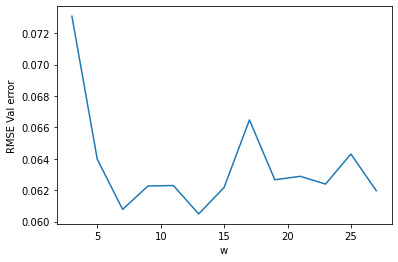

In [ ]:
plt.plot([3 + 2*i for i in range(13)],np.sqrt(final_val))
plt.xlabel("w")
plt.ylabel("RMSE Val error")

We notice that the rmse validation error doesnt vary much with change in w, It sharply decreases initially by after w = 7, it more or less remains contant with the rmse validation error hovering arounf 6%
This is a nice result considering how basic (one convolution layer and one linear layer) our model was.

### **Varying Model Complexity**

Let us now fix w = 13 and try out a different model which is slightly more complex. We will train it for a few more epochs and see if this model performs better or not

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 10,kernel_size = 3,stride = 2) #6,6,16
    self.conv2 = nn.Conv2d(in_channels = 10,out_channels = 25,kernel_size = 3,stride = 1) #4,4,25
    self.fc1 = nn.Linear(4*4*25, 100)
    self.fc2 = nn.Linear(100, 30)
    self.fc3 = nn.Linear(30, 3)
    
    
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))

    x = x.view(-1, 4*4*25)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    


In [ ]:

for w in [13]:
  subpatches = subpatch(w,patches)

  subpatch_2 = subpatches.reshape((200*num,w,w,3)).astype("uint8")
  central_2 = central.reshape((200*num,1,1,3)).astype("uint8")

  X_train, X_val, y_train, y_val = train_test_split(subpatch_2, central_2, test_size=0.20, random_state=42)

  batch_size = 96

  transformed_dataset_train = BSDSDataset(X_train,y_train)
  transformed_dataset_val = BSDSDataset(X_val,y_val)

  dl_train = DataLoader(transformed_dataset_train, batch_size, shuffle=True, num_workers=2)
  dl_val = DataLoader(transformed_dataset_val, X_val.shape[0], shuffle=True, num_workers=2)

  num_epochs = 40
  learning_rate = 0.0005

  model = ConvNet()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  total_steps = len(dl_train) #total train size/batch_size

  print(f'Training CNN for w = {w}')
  for epoch in range(num_epochs):
    for i, (images,target) in enumerate(dl_train):

      #Feed forward
      output = model(images)
      target = torch.reshape(target, (batch_size,3))
      loss = criterion(output, target)

      
      # Backward and optimize
      optimizer.zero_grad() #Clear the gradients
      loss.backward()       #Backprop
      optimizer.step()      #Update weights

      

      if (i+1)%100 == 0:
        #Calculate val loss
        for j, (images,target) in enumerate(dl_val):
          output = model(images)
          target = torch.reshape(target, (2400,3))
          loss_val = criterion(output, target)
          print(f'Epoch: {epoch}/{num_epochs}, Iteration: {i+1}/{total_steps},RMSE Val Loss = {np.sqrt(loss_val.detach().numpy())},RMSE Train Loss = {np.sqrt(loss.detach().numpy())}') 
  print("Finished training")

  # print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i+1}/{total_steps},RMSE Val Loss = {np.sqrt(loss_val.detach().numpy())},RMSE Train Loss = {np.sqrt(loss.detach().numpy())}') 
  print("------------------------------")
  final_val = loss_val

Training CNN for w = 13
Epoch: 0/40, Iteration: 100/100,RMSE Val Loss = 0.08824954181909561,RMSE Train Loss = 0.07906040549278259
Epoch: 1/40, Iteration: 100/100,RMSE Val Loss = 0.07859892398118973,RMSE Train Loss = 0.06854698061943054
Epoch: 2/40, Iteration: 100/100,RMSE Val Loss = 0.0738641768693924,RMSE Train Loss = 0.06732393801212311
Epoch: 3/40, Iteration: 100/100,RMSE Val Loss = 0.07097998261451721,RMSE Train Loss = 0.08576394617557526
Epoch: 4/40, Iteration: 100/100,RMSE Val Loss = 0.06750981509685516,RMSE Train Loss = 0.06571373343467712
Epoch: 5/40, Iteration: 100/100,RMSE Val Loss = 0.06272248923778534,RMSE Train Loss = 0.06413319706916809
Epoch: 6/40, Iteration: 100/100,RMSE Val Loss = 0.06198357045650482,RMSE Train Loss = 0.0663493424654007
Epoch: 7/40, Iteration: 100/100,RMSE Val Loss = 0.06075024604797363,RMSE Train Loss = 0.05335671454668045
Epoch: 8/40, Iteration: 100/100,RMSE Val Loss = 0.06061352416872978,RMSE Train Loss = 0.06257040798664093
Epoch: 9/40, Iteration: 

We see that we have a 5.5% rmse, a very slight improvement from the previous model. So we can conclude that although the model improves its perfomance, its quite negligible (roughly a .5 percent improvement)

### **Testing the model on held-out or private images (CNN)**

We will now test our model on a few test images. We will first load the image, degrade it. Then we will initialise a clean image. We will loop over all degraded patches and restore the central clean pixel using our model. 

Note that we will need some transformation to convert the degraded patch into CNN readable format.

I have defined a function which does all this and ouputs the final image along with the original image so that we test it on a few images

In [ ]:
for i, (images,target) in enumerate(dl_test):
  print(images.dtype)
  outputs = model(images)
  print(outputs.shape,target.shape) 
  outputs = outputs.detach().numpy()
  target = target.detach().numpy().reshape(2400,3)

print(outputs.shape,target.shape) 
diff = outputs - target
mse = np.sum(diff**2,0)/2400
print(mse)
rmse = np.sqrt(mse)
print(rmse)
rmse.mean()


torch.float32
torch.Size([2400, 3]) torch.Size([2400, 3, 1, 1])


In [ ]:
from PIL import Image, ImageEnhance

In [ ]:

def model_test(im):
  orig, degraded = degrade(im)
  degraded_norm = ((degraded/255.0))
  degraded_norm = degraded_norm.astype('float32')
  
  clean_pred = np.empty(((im.shape[0] - w + 1),(im.shape[1] - w + 1),3), dtype=float)

  for i in range(im.shape[0] - w + 1):
    for j in range(im.shape[1] - w + 1):
      x = torch.tensor(degraded_norm[i:i+w,j:j+w,:])
      x = torch.transpose(x,0,1)
      x = torch.transpose(x,0,2)
      x = x.reshape((1,3,w,w))
      clean_pred[i,j,:] = model(x).detach().numpy()

  cleaned = cv2.convertScaleAbs((clean_pred*255.0))
  
  cv2_imshow(orig)
  cv2_imshow(degraded)
  cv2_imshow(cleaned)


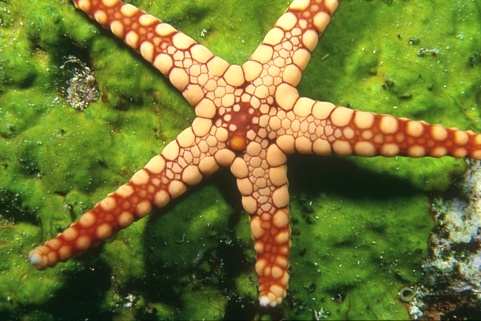

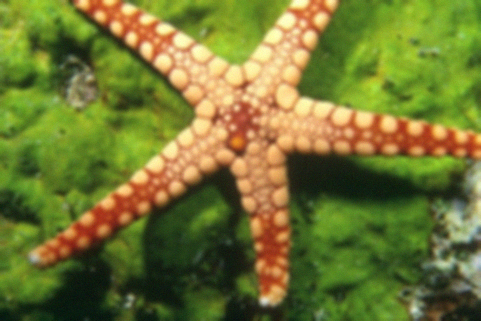

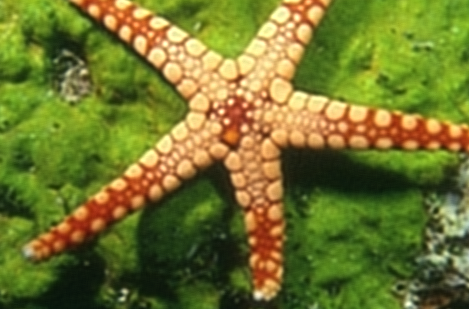

In [ ]:
im = cv2.imread('/content/drive/MyDrive/EE610_Assignment2/images/train/12003.jpg')
model_test(im)

In the above example we can see that our model decently cleans up the degraded image. It is not the same as the original image but we can see that it has been **sharpened to some extent** and **some detail which was lost** during degradation is restored back.

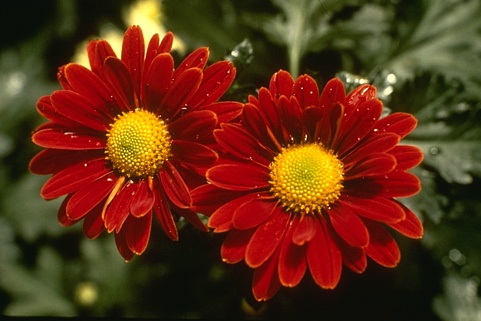

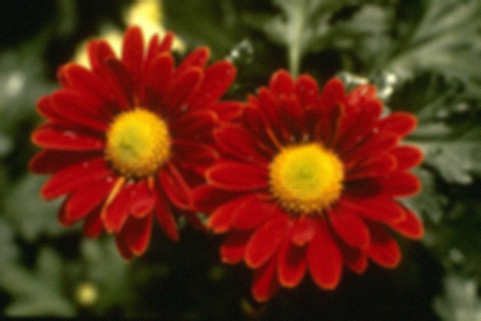

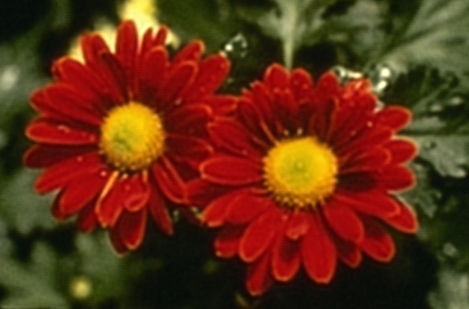

In [ ]:
im = cv2.imread('/content/drive/MyDrive/EE610_Assignment2/images/train/124084.jpg')
model_test(im)

Even here we notice that some detail such as the white dots on the flower and some background which was blurred out due to the degradtion has been restored by our model. Again, it is not as perfect as the original image but it has been restored to quite some extent

## **Final Observations and Comments**

We observe that the CNNs gave a similar performance over the Support Vector Machines. I had initially expected CNNs to perform much better over SVM but in reality they both had comparable results. One advantage of CNNs were that they were really quick in cleaning up a new image (they took around 10 seconds in comparision to 4 minutes for SVMs). So I had to work with small windows for SVMs while training (only till 13). I believe by further tuning the CNNs we can achieve a better performance.

Another surprising relevation was that the performance of CNNs were almost independent on the size of w. I had initially expected that higher window size will naturally lead to better performance but in practice, size of the window really did not matter and we actually had w = 13 as the most optimum window size. A reason for this could be that since we are predicting only a central pixel, we only need the immediate neighbouring pixels (a 3*3 or a 5*5 at max). A higher w could lead to extra information which is not really needed and hence the performance saturates. This trend was also observed in SVMs where the error was almost constant, infact the error increased after w = 5 and this value of w was the optimum value

Finally, I also expected a more complex CNN to work better which it did but not by much. This was another surprising observation which I noticed
